In [11]:
# Import libraries
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from scipy.ndimage import convolve
import pywt
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Mount Google Drive
drive.mount('/content/drive')

# Install required libraries
!pip install scikit-image PyWavelets tensorflow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Define paths
data_dir = '/content/drive/MyDrive/SOC_2025/week3/example_images/'
output_dir = '/content/drive/MyDrive/SOC_2025/week3/advanced_images/'
os.makedirs(output_dir, exist_ok=True)
image_paths = sorted(glob.glob(os.path.join(data_dir, 'image*_lesion.png')))
print(f"Found {len(image_paths)} images")

Found 50 images


In [14]:
# Week 3 Preprocessing Functions (Included for Self-Containment)
def preprocess_image(img):
    """Apply Gaussian blur and CLAHE for noise reduction and contrast enhancement."""
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    img_gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img_gray)
    return enhanced, blurred

def segment_red_spots(img):
    """Segment microaneurysms and hemorrhages using HSV thresholding."""
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_channel = img[:,:,2]
    _, thresh_red = cv2.threshold(red_channel, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh_red

def segment_exudates(img):
    """Segment exudates using Lab color space and morphological operations."""
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    l_channel = img_lab[:,:,0]
    _, thresh_exudates = cv2.threshold(l_channel, 200, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    exudate_refined = cv2.morphologyEx(thresh_exudates, cv2.MORPH_CLOSE, kernel)
    return exudate_refined

def segment_vessels(img_gray):
    """Segment blood vessels using Frangi filter."""
    vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)
    vessels_refined = (vessels > np.percentile(vessels, 97)).astype(np.uint8) * 255
    return vessels_refined

In [15]:
# Week 4 Advanced Processing Functions
def advanced_preprocess(img_gray):
    """Apply optimized CLAHE and curvelet-based enhancement."""
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
    enhanced_advanced = clahe.apply(img_gray)
    # Curvelet enhancement (simplified)
    coeffs = pywt.wavedec2(img_gray, 'db1', level=2)
    coeffs[1:] = [tuple(c * 1.5 for c in level) for level in coeffs[1:]]
    curvelet_enhanced = pywt.waverec2(coeffs, 'db1')
    curvelet_enhanced = np.clip(curvelet_enhanced, 0, 255).astype(np.uint8)
    return enhanced_advanced, curvelet_enhanced

def texture_filter_ma(img_gray):
    """Apply texture filter for microaneurysms (approximating LNDCP)."""
    kernel_lndcp = np.ones((3,3)) / 9
    texture = convolve(img_gray, kernel_lndcp)
    _, thresh_ma = cv2.threshold(texture, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh_ma

In [16]:
# Automated Detection with Contours
def detect_lesions(img, exudate_mask):
    """Detect exudates using contours."""
    contours, _ = cv2.findContours(exudate_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)
    return img_contours, len(contours)

In [17]:
# Batch Processing
for path in image_paths:
    # Load image
    img = cv2.imread(path)
    if img is None:
        print(f"Failed to load {path}")
        continue

    # Week 3 preprocessing
    enhanced, blurred = preprocess_image(img)
    red_spots = segment_red_spots(blurred)
    exudate_mask = segment_exudates(blurred)
    vessels = segment_vessels(enhanced)

    # Week 4 advanced processing
    enhanced_advanced, curvelet_enhanced = advanced_preprocess(enhanced)
    ma_mask = texture_filter_ma(enhanced)

    # Automated detection
    img_contours, num_lesions = detect_lesions(img, exudate_mask)

    # Save results
    base_name = os.path.basename(path).replace('.png', '')
    cv2.imwrite(os.path.join(output_dir, f'{base_name}_advanced.png'), enhanced_advanced)
    cv2.imwrite(os.path.join(output_dir, f'{base_name}_curvelet.png'), curvelet_enhanced)
    cv2.imwrite(os.path.join(output_dir, f'{base_name}_contours.png'), img_contours)
    print(f"Processed {base_name}: {num_lesions} lesions detected")

/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image001_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image002_lesion: 6 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image003_lesion: 5 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image004_lesion: 5 lesions detected
Processed image005_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image006_lesion: 10 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image007_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image008_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image009_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image010_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image011_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image012_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image013_lesion: 17 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image014_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image015_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image016_lesion: 10 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image017_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image018_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image019_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image020_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image021_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image022_lesion: 5 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image023_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image024_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image025_lesion: 5 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image026_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image027_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image028_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image029_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image030_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image031_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image032_lesion: 5 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image033_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image034_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image035_lesion: 5 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image036_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image037_lesion: 7 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image038_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image039_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image040_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image041_lesion: 5 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image042_lesion: 9 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image043_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image044_lesion: 6 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image045_lesion: 11 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image046_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image047_lesion: 3 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image048_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image049_lesion: 4 lesions detected


/tmp/ipython-input-14-2004357268.py:28: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img_gray, scale_range=(1, 10), scale_step=2)


Processed image050_lesion: 3 lesions detected


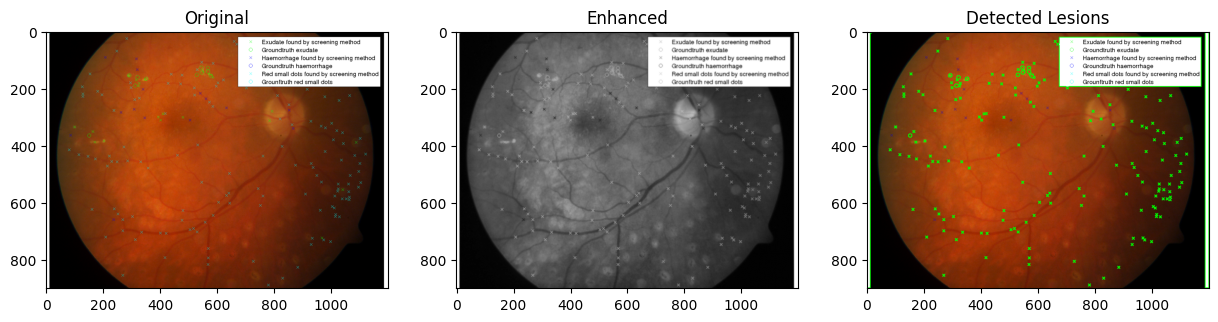

In [18]:
# Visualization (example for first image)
img = cv2.imread(image_paths[0])
enhanced, _ = preprocess_image(img)
exudate_mask = segment_exudates(img)
img_contours, _ = detect_lesions(img, exudate_mask)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(1,3,2), plt.imshow(enhanced, cmap='gray'), plt.title('Enhanced')
plt.subplot(1,3,3), plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)), plt.title('Detected Lesions')
plt.show()